In [ ]:
!pip install scikit-image
!pip install scikit-learn
!pip install seaborn

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.9 MB 10.7 MB/s eta 0:00:02
   ------------- -------------------------- 4.2/12.9 MB 10.5 MB/s eta 0:00:01
   -------------------- ------------------- 6.6/12.9 MB 10.9 MB/s eta 0:00:01
   -------------------------- ------------- 8.7/12.9 MB 10.5 MB/s eta 0:00:01
   ---------------------------------- ----- 11.0/12.9 MB 10.6 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.9 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 9.9 MB/s eta 0:00:00
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------------------------- -------- 1.3/1.6 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 6.3 MB/s eta 0:00:00
   --------------------------------------

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Paths to train and test sets
data_path = 'KTH_TIPS'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

# Parameters for LBP
radius = 3
n_points = 8 * radius
method = 'uniform'
k_clusters = 50

# Function to extract LBP histogram
def extract_lbp_features(image_path):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)
    lbp = local_binary_pattern(image_gray, n_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    return hist

# Load images and extract LBP features for training
def load_data_and_extract_features(data_dir):
    features = []
    labels = []
    classes = os.listdir(data_dir)
    for label in classes:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                hist = extract_lbp_features(image_path)
                features.append(hist)
                labels.append(label)
    return np.array(features), np.array(labels)

# Extract features and labels for training and testing
print("Loading and extracting training data...")
train_features, train_labels = load_data_and_extract_features(train_path)

print("Loading and extracting test data...")
test_features, test_labels = load_data_and_extract_features(test_path)

Loading and extracting training data...


c:\Users\umutc\Anaconda3\envs\compvision\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Loading and extracting test data...


In [21]:
# Create visual vocabulary using k-means
print("Creating visual vocabulary with k-means...")
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
kmeans.fit(train_features)

# Convert features to Bag-of-Words histogram representation
def convert_to_bow_histograms(features, kmeans_model, num_clusters):
    histograms = []
    for feature in features:
        labels = kmeans_model.predict(feature.reshape(1, -1))
        hist, _ = np.histogram(labels, bins=np.arange(num_clusters + 1), density=True)
        histograms.append(hist)
    return np.array(histograms)

train_bow = convert_to_bow_histograms(train_features, kmeans, k_clusters)
test_bow = convert_to_bow_histograms(test_features, kmeans, k_clusters)

# Normalize data
scaler = StandardScaler()
train_bow = scaler.fit_transform(train_bow)
test_bow = scaler.transform(test_bow)

# k-NN classifier
print("Training k-NN classifier...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_bow, train_labels)

# Predict on test set
print("Predicting on test data...")
predictions = knn.predict(test_bow)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, predictions))

Creating visual vocabulary with k-means...
Training k-NN classifier...
Predicting on test data...
Classification Report:
                precision    recall  f1-score   support

aluminium_foil       0.39      0.88      0.54        25
   brown_bread       0.24      0.36      0.29        25
      corduroy       0.34      0.52      0.41        25
        cotton       0.45      0.56      0.50        25
       cracker       0.19      0.20      0.20        25
         linen       0.67      0.32      0.43        25
   orange_peel       0.50      0.08      0.14        25
     sandpaper       0.55      0.48      0.51        25
        sponge       0.83      0.20      0.32        25
     styrofoam       0.88      0.60      0.71        25

      accuracy                           0.42       250
     macro avg       0.50      0.42      0.41       250
  weighted avg       0.50      0.42      0.41       250



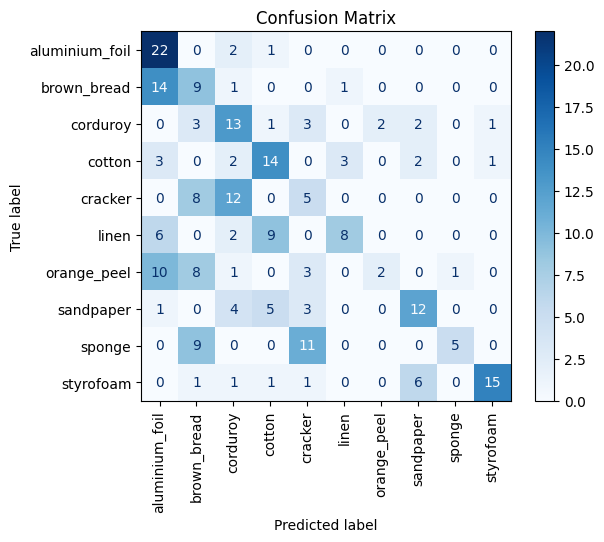

In [24]:
import seaborn as sns
# Confusion matrix
display = ConfusionMatrixDisplay.from_estimator(knn, test_bow, test_labels, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


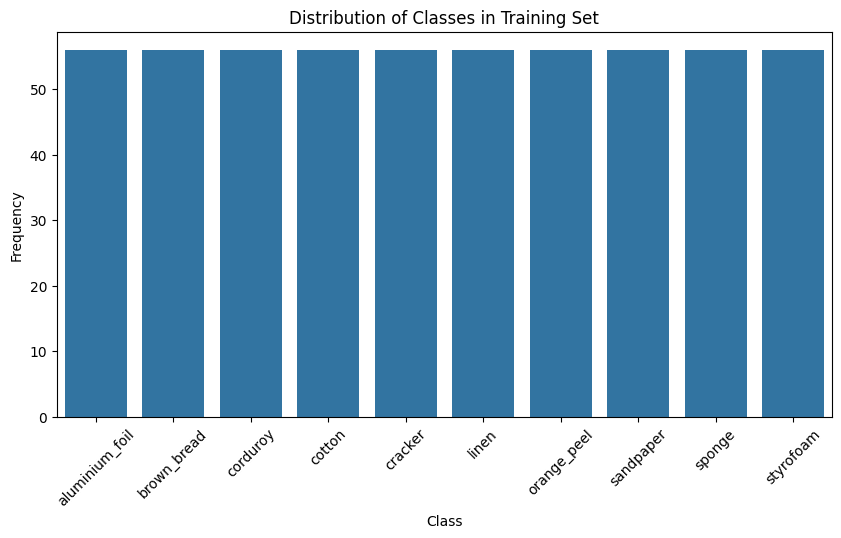

In [ ]:
# Data exploration: Visualize the distribution of classes in the training set
plt.figure(figsize=(10, 5))
sns.countplot(x=train_labels, order=np.unique(train_labels))
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Visualizing some classified examples...


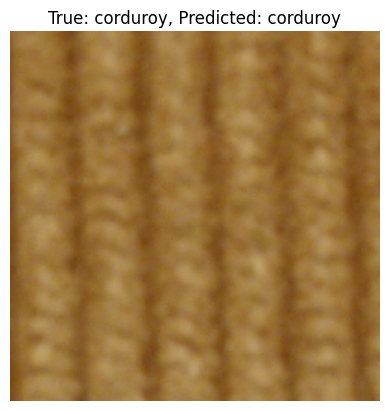

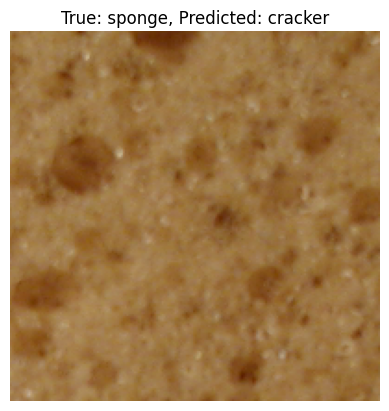

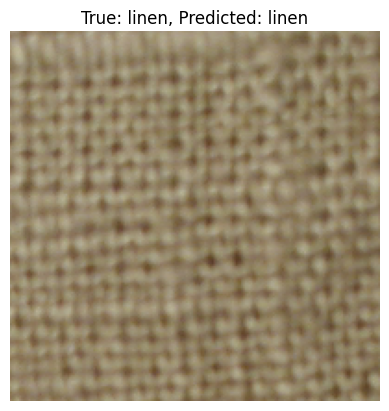

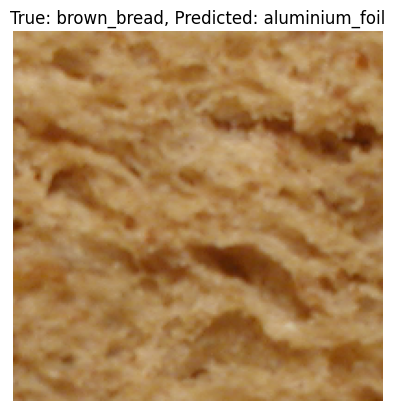

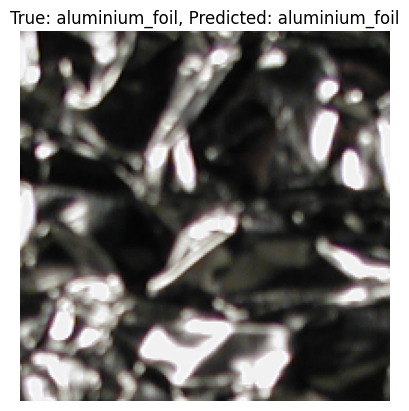

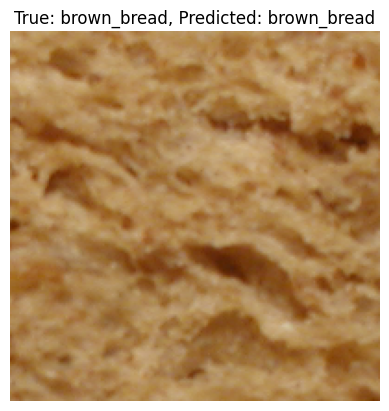

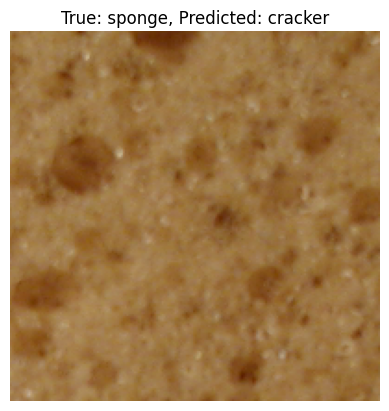

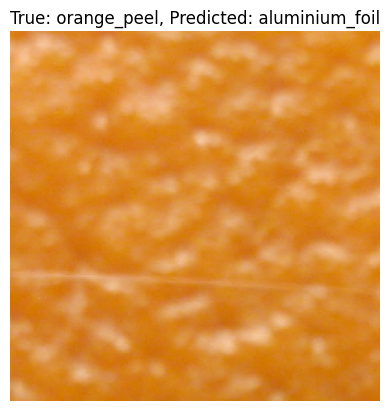

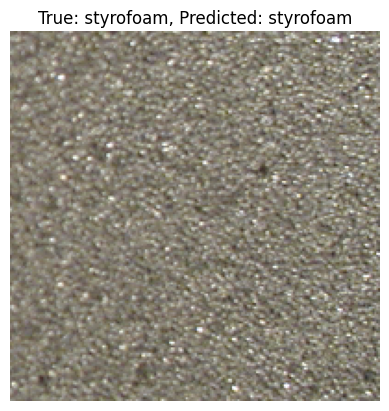

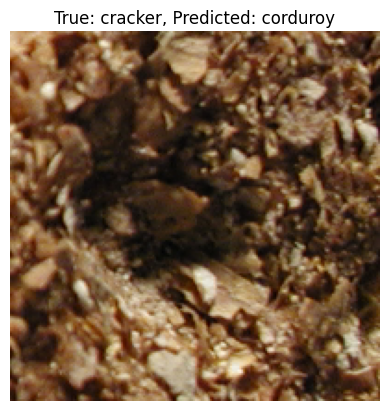

In [26]:
# Visualize some classified examples from the test set
print("Visualizing some classified examples...")
sample_indices = np.random.choice(len(test_labels), 10, replace=False)

for idx in sample_indices:
    image_path = os.path.join(test_path, test_labels[idx], os.listdir(os.path.join(test_path, test_labels[idx]))[0])
    image = io.imread(image_path)
    plt.imshow(image)
    plt.title(f"True: {test_labels[idx]}, Predicted: {predictions[idx]}")
    plt.axis('off')
    plt.show()